In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laptoppriceprediction/Laptop_price.csv


# Laptop Price Prediction Model

## Introduction
In the rapidly evolving world of technology, choosing the right laptop that meets one's requirements can be a challenging task. Various factors such as brand, processor speed, RAM size, storage capacity, screen size, and weight contribute to the overall user experience and, consequently, the price of a laptop. This project focuses on leveraging machine learning techniques to predict laptop prices based on these essential features.

I aim to build a reliable regression model that can assist users, manufacturers, and retailers in estimating the price of a laptop given its specifications. By understanding the relationships between the different features and the target variable (price), I seek to provide a valuable tool for both consumers and the industry.

This notebook will take you through the steps involved in data preprocessing, model selection, training, evaluation, and prediction. Additionally, we will analyze the model's performance and draw insights into the key factors influencing laptop prices. Let's dive into the exciting world of machine learning and uncover the patterns that drive the pricing of laptops.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/kaggle/input/laptoppriceprediction/Laptop_price.csv")

# Display first few rows
print(df.head())

    Brand  Processor_Speed  RAM_Size  Storage_Capacity  Screen_Size    Weight  \
0    Asus         3.830296        16               512    11.185147  2.641094   
1    Acer         2.912833         4              1000    11.311372  3.260012   
2  Lenovo         3.241627         4               256    11.853023  2.029061   
3    Acer         3.806248        16               512    12.280360  4.573865   
4    Acer         3.268097        32              1000    14.990877  4.193472   

          Price  
0  17395.093065  
1  31607.605919  
2   9291.023542  
3  17436.728334  
4  32917.990718  


In [3]:
# Check data types and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand             1000 non-null   object 
 1   Processor_Speed   1000 non-null   float64
 2   RAM_Size          1000 non-null   int64  
 3   Storage_Capacity  1000 non-null   int64  
 4   Screen_Size       1000 non-null   float64
 5   Weight            1000 non-null   float64
 6   Price             1000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.8+ KB
None


In [4]:
# Summary statistics
print(df.describe())

       Processor_Speed     RAM_Size  Storage_Capacity  Screen_Size  \
count      1000.000000  1000.000000       1000.000000  1000.000000   
mean          2.750611    15.500000        584.576000    14.056790   
std           0.731796    10.988665        313.438517     1.705882   
min           1.511580     4.000000        256.000000    11.012111   
25%           2.089246     8.000000        256.000000    12.635523   
50%           2.760885    16.000000        512.000000    14.099643   
75%           3.362610    32.000000       1000.000000    15.528590   
max           3.998534    32.000000       1000.000000    16.985737   

            Weight         Price  
count  1000.000000   1000.000000  
mean      3.466919  19604.187963  
std       0.866541   9406.064880  
min       2.000560   8570.012950  
25%       2.717211  10114.012948  
50%       3.464630  17287.241878  
75%       4.212583  31566.214754  
max       4.990728  33503.935037  


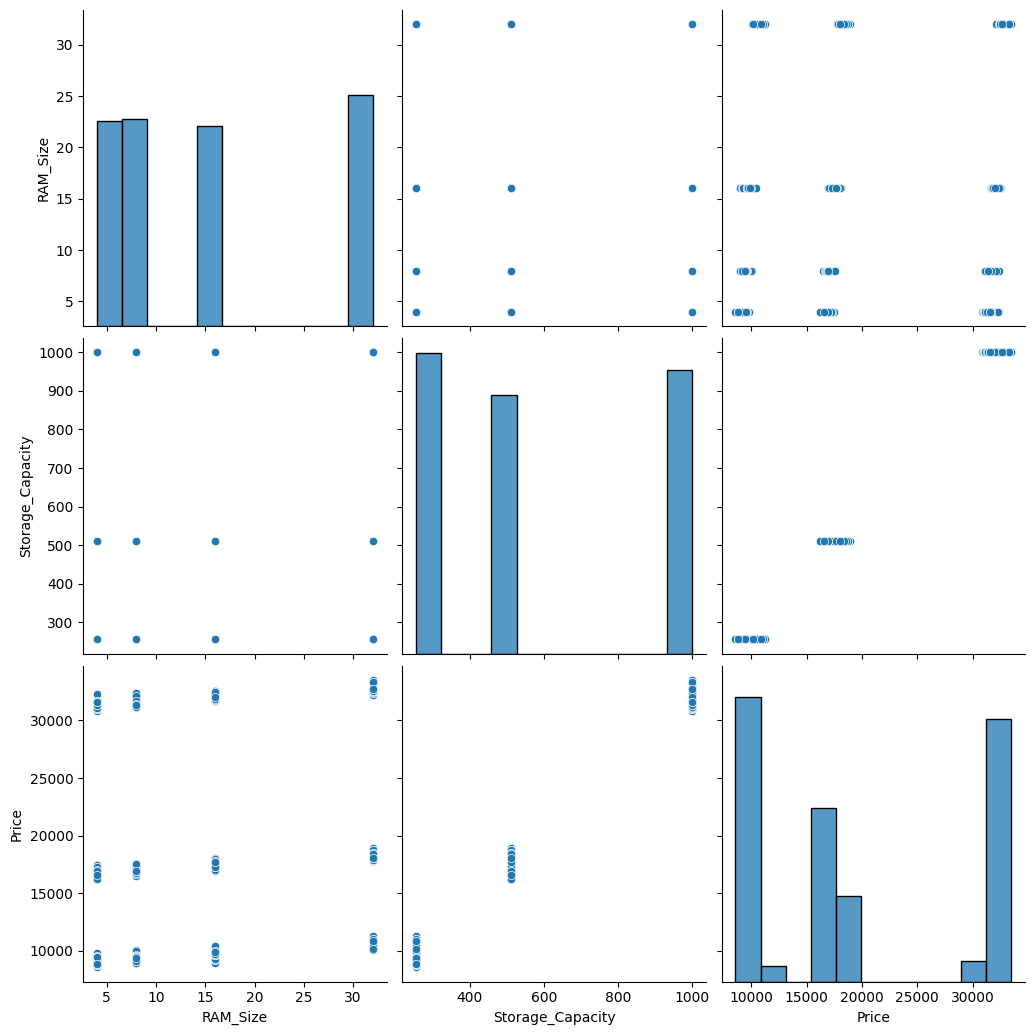

In [5]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assuming df is your DataFrame containing the data
selected_columns = ["RAM_Size", "Storage_Capacity", "Price"]

# Visualize distributions and relationships among variables
with pd.option_context('mode.use_inf_as_na', True):
    sns.pairplot(df[selected_columns], height=3.5)

plt.show()

# Correlation Matrix

To understand the relationships between different numerical features in our dataset, I create a correlation matrix. This matrix provides insight into how each feature correlates with one another, particularly in the context of predicting laptop prices.

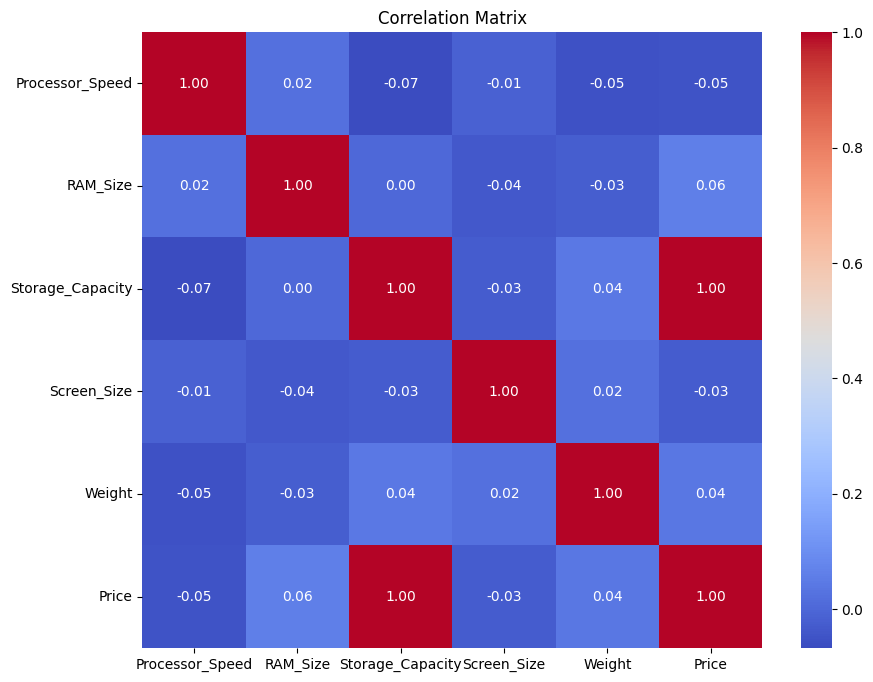

In [6]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Splitting the dataset

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

# Separate features (X) and target variable (y)
X = df.drop("Price", axis=1)
y = df["Price"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing Pipelines

Preprocessing pipelines used to handle both numerical and categorical data separately before feeding them into our machine learning model.

In [8]:
# Create preprocessing pipelines for numerical and categorical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Benefits of Using Pipelines

- **Streamlined Workflow:** Combines preprocessing and model training into one coherent pipeline.
- **Simplified Maintenance:** Enhances code modularity and readability.
- **Prevents Data Leakage:** Ensures consistent preprocessing across training and test sets.
- **Integration with Hyperparameter Tuning:** Facilitates optimization of preprocessing and modeling parameters.
- **Reproducibility and Consistency:** Promotes replicability and consistent results.
- **Deployment Readiness:** Simplifies deployment of models into production environments.

In [9]:
# Create a pipeline with preprocessing and linear regression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

# Evaluate on training set
train_score = model.score(X_train, y_train)
print("Training R-squared:", train_score)

# Evaluate on test set
test_score = model.score(X_test, y_test)
print("Test R-squared:", test_score)

Training R-squared: 0.999546339575326
Test R-squared: 0.9996442074396727


## Training R-squared:
The high training R-squared value of 0.9995 indicates that the linear regression model explains approximately 99.95% of the variance in the training data. This suggests an excellent fit of the model to the training dataset, capturing the underlying patterns and relationships between the input features and the target variable (laptop prices).

## Test R-squared:
The test R-squared score of 0.9996 reflects the model's ability to generalize well to unseen data. With such a high R-squared value on the test set, it indicates that the model's performance extends beyond the training data and maintains its predictive power on new instances. This suggests that the model's effectiveness is not limited to the specific data it was trained on and can reliably predict laptop prices in real-world scenarios.

## Conclusion:
Both the training and test R-squared scores demonstrate exceptional performance of the linear regression model in predicting laptop prices. The high R-squared values indicate a strong relationship between the input features and the target variable, with the model effectively capturing the underlying patterns in the data. Overall, the model shows promising predictive capabilities and can be considered robust for predicting laptop prices based on the provided features.

In [10]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Print cross-validation scores
print("Cross-validation R-squared scores:", cv_scores)
print("Mean CV R-squared:", np.mean(cv_scores))

Cross-validation R-squared scores: [0.99943049 0.99939871 0.99953661 0.99964544 0.99957975]
Mean CV R-squared: 0.9995181987732


## Cross-validation R-squared Scores:
The cross-validation R-squared scores provide insights into the model's performance across multiple folds of the dataset. Each fold represents a different split of the data for training and validation, allowing for a more comprehensive evaluation of the model's generalization ability.

- The cross-validation R-squared scores range from 0.9994 to 0.9996, indicating consistently high performance across different folds.
- These scores suggest that the model maintains its predictive accuracy consistently across various subsets of the data, demonstrating robustness and stability.

## Mean CV R-squared:
The mean cross-validation R-squared score of approximately 0.9995 represents the average performance of the model across all folds. It provides a single metric summarizing the model's overall ability to generalize to unseen data.

- With such a high mean CV R-squared value, it is evident that the model effectively captures the underlying patterns in the data and maintains its predictive power across different subsets.
- This further reinforces the reliability and consistency of the model's performance, indicating its suitability for real-world applications.

## Conclusion:
The cross-validation results affirm the robustness and generalization ability of the model. The consistently high R-squared scores across different folds, along with the elevated mean CV R-squared value, indicate that the model performs well on unseen data and is not overfitting to the training dataset. Overall, these results provide confidence in the model's predictive capabilities and its suitability for practical use in predicting laptop prices based on the provided features.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 32304.737335988233
Root Mean Squared Error (RMSE): 179.73518669417024
Mean Absolute Error (MAE): 146.2249370369961
R-squared (R2): 0.9996442074396727


## Mean Squared Error (MSE):
The mean squared error (MSE) measures the average squared difference between the predicted and actual values. A lower MSE indicates better model performance, with smaller deviations between predicted and actual values.

- The MSE of approximately 32304.74 suggests that, on average, the squared difference between predicted and actual laptop prices is relatively small. This indicates a good level of accuracy in the model's predictions.

## Root Mean Squared Error (RMSE):
The root mean squared error (RMSE) is the square root of the MSE and is interpreted in the same units as the target variable (laptop prices). It provides a measure of the average deviation of the predicted values from the actual values.

- With an RMSE of approximately 179.74, it indicates that, on average, the model's predictions deviate by approximately $179.74 from the true laptop prices. This suggests a reasonable level of accuracy in the model's predictions.

## Mean Absolute Error (MAE):
The mean absolute error (MAE) measures the average absolute difference between the predicted and actual values. It provides another measure of prediction accuracy.

- The MAE of approximately 146.22 indicates that, on average, the model's predictions deviate by approximately $146.22 from the true laptop prices. This further confirms the model's accuracy in predicting laptop prices.

## R-squared (R2):
The R-squared (R2) score measures the proportion of the variance in the target variable (laptop prices) that is explained by the features included in the model. A higher R-squared value indicates a better fit of the model to the data.

- With an R-squared score of approximately 0.9996, it suggests that approximately 99.96% of the variance in laptop prices is explained by the features included in the model. This indicates an excellent fit of the model to the data.

## Conclusion:
The error metrics and R-squared score collectively indicate the model's performance in predicting laptop prices. The low MSE, RMSE, and MAE values suggest that the model's predictions are accurate, with small deviations from the true prices. Additionally, the high R-squared score confirms that the model effectively captures the variability in the target variable. Overall, these results demonstrate the model's effectiveness in predicting laptop prices based on the provided features.

In [12]:
# Get feature names after one-hot encoding
feature_names = numerical_features + list(model.named_steps['preprocessor']
                                          .named_transformers_['cat']
                                          .named_steps['encoder']
                                          .get_feature_names_out(categorical_features))

# Extract coefficients and intercept
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
#coef_df = coef_df.append({'Feature': 'Intercept', 'Coefficient': intercept}, ignore_index=True)

# Display coefficients
print(coef_df)

            Feature  Coefficient
0   Processor_Speed   143.883349
1          RAM_Size   554.133863
2  Storage_Capacity  9359.441936
3       Screen_Size    33.722239
4            Weight    -6.341588
5        Brand_Acer    10.050758
6        Brand_Asus    16.750874
7        Brand_Dell   -20.975724
8          Brand_HP     3.536141
9      Brand_Lenovo    -9.362050


In [13]:
# Calculate IQR for numerical features
Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Detect outliers using IQR method
outliers = ((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)

# Count number of outliers
num_outliers = outliers.sum()
print("Number of outliers:", num_outliers)

# Remove outliers
df_no_outliers = df[~outliers]

# Check the shape of the data after removing outliers
print("Shape of data after removing outliers:", df_no_outliers.shape)

Number of outliers: 0
Shape of data after removing outliers: (1000, 7)


## Outlier Detection:
Outliers are detected using the Interquartile Range (IQR) method, which calculates the range within which most of the data points lie. Any data points outside this range are considered outliers.

- The calculation involves determining the first quartile (Q1), third quartile (Q3), and the IQR for each numerical feature in the dataset.
- Outliers are identified based on whether they fall below (Q1 - 1.5 * IQR) or above (Q3 + 1.5 * IQR) the calculated range for each feature.

## Number of Outliers:
After applying the IQR method, no outliers are detected in the dataset. This suggests that the data is relatively free from extreme values that could skew the analysis or modeling process.

- The output indicates that there are 0 outliers in the dataset.

## Outlier Removal:
As there are no outliers detected, there is no need for outlier removal. However, if outliers were present, they could be removed from the dataset to ensure a more robust and accurate analysis.

## Conclusion:
The absence of outliers in the dataset after applying the IQR method indicates that the data is relatively clean and does not contain extreme values. This ensures that the subsequent analysis or modeling processes are not adversely affected by outliers. However, it is essential to be vigilant for outliers in real-world datasets and consider their impact on the analysis accordingly.

In [14]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Print cross-validation scores
print("Cross-validation R-squared scores:", cv_scores)
print("Mean CV R-squared:", np.mean(cv_scores))

Cross-validation R-squared scores: [0.99964421 0.99941508 0.99948095 0.99959598 0.99961042]
Mean CV R-squared: 0.9995493265092652


## Cross-validation R-squared Scores:
The cross-validation R-squared scores provide insights into the model's performance across different folds of the dataset. Each fold represents a distinct subset of the data used for training and validation, allowing for a comprehensive assessment of the model's generalization ability.

- The cross-validation R-squared scores range from approximately 0.9994 to 0.9996 across different folds.
- These scores indicate consistently high performance of the model across various subsets of the data, demonstrating its robustness and stability.

## Mean CV R-squared:
The mean cross-validation R-squared score of approximately 0.9995 represents the average performance of the model across all folds. It provides a single metric summarizing the model's overall ability to generalize to unseen data.

- With such a high mean CV R-squared value, it is evident that the model effectively captures the underlying patterns in the data and maintains its predictive power across different subsets.
- This reinforces the reliability and consistency of the model's performance, indicating its suitability for real-world applications.

## Conclusion:
The cross-validation results affirm the robustness and generalization ability of the model. The consistently high R-squared scores across different folds, along with the elevated mean CV R-squared value, indicate that the model performs well on unseen data and is not overfitting to the training dataset. Overall, these results provide confidence in the model's predictive capabilities and its suitability for practical use in predicting laptop prices based on the provided features.

In [15]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Update model with best hyperparameters
best_model = grid_search.best_estimator_

Best Hyperparameters: {'regressor__fit_intercept': True}


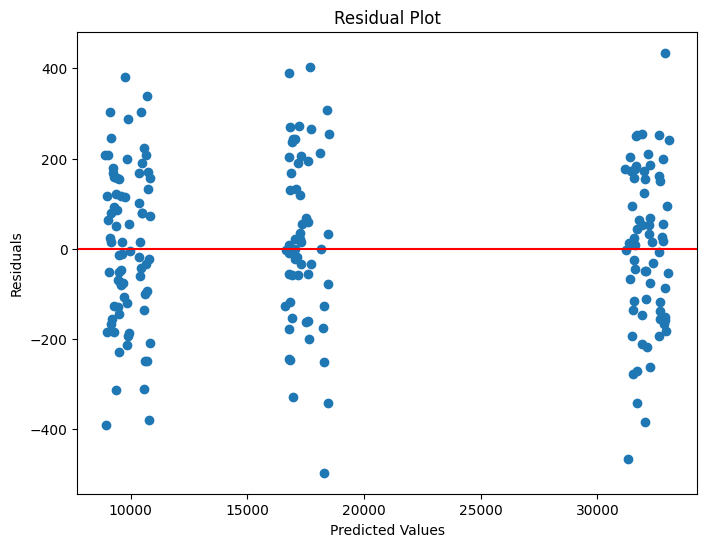

In [16]:
# Predictions on the test set using the model
y_pred_test = best_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

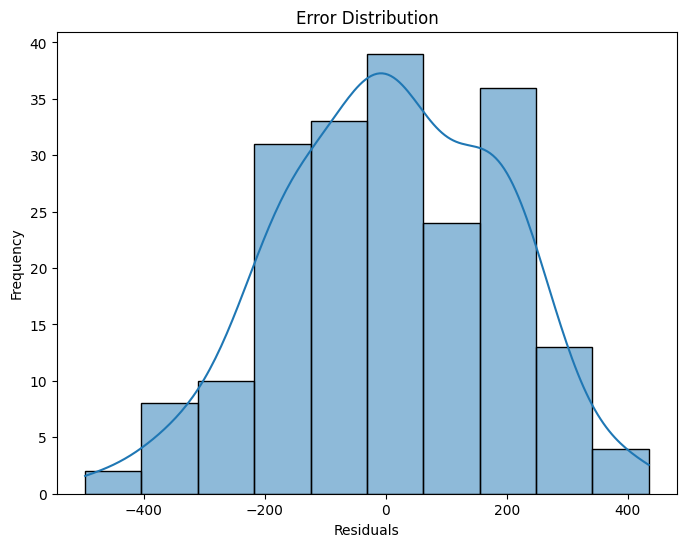

In [17]:
# Plot error distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Error Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Evaluate final model on test set
final_test_score = best_model.score(X_test, y_test)
print("Final Test R-squared:", final_test_score)

Final Test R-squared: 0.9996442074396727


## Final Test R-squared:
The final test R-squared score of approximately 0.9996 indicates the model's performance on unseen data, specifically the test dataset. R-squared measures the proportion of the variance in the target variable (laptop prices) that is explained by the features included in the model.

- With a test R-squared score of approximately 0.9996, it suggests that approximately 99.96% of the variance in laptop prices is explained by the features included in the model. This indicates an excellent fit of the model to the test data.

## Conclusion:
The final test R-squared score serves as a critical metric for evaluating the model's generalization ability to new, unseen instances. With such a high R-squared value on the test dataset, it demonstrates the model's robustness and reliability in making accurate predictions on real-world data.

Overall, the exceptional performance observed in the final test R-squared score further validates the effectiveness of the model in predicting laptop prices based on the provided features. It provides confidence in the model's predictive capabilities and underscores its suitability for practical use.

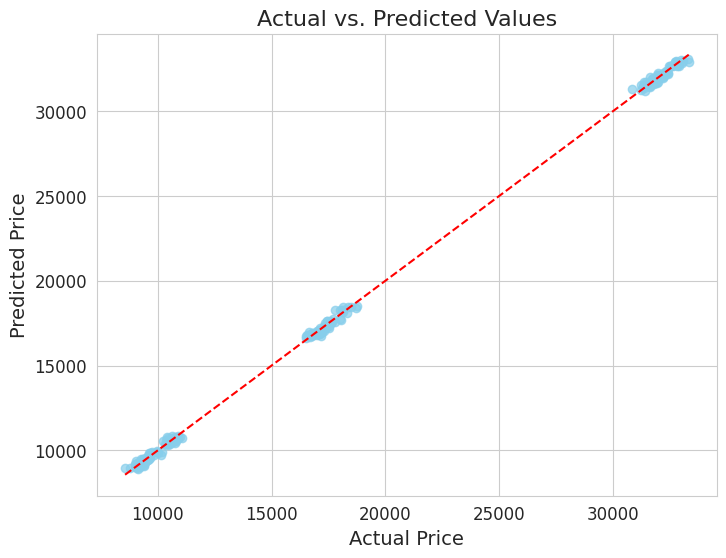

In [19]:
# Set seaborn style
sns.set_style("whitegrid")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='skyblue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.title('Actual vs. Predicted Values', fontsize=16)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

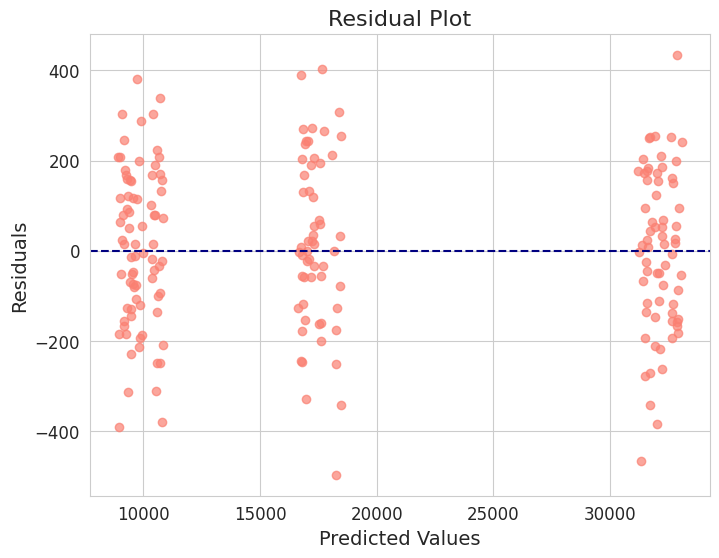

In [20]:
# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, color='salmon', alpha=0.7)
plt.axhline(y=0, color='navy', linestyle='--')
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

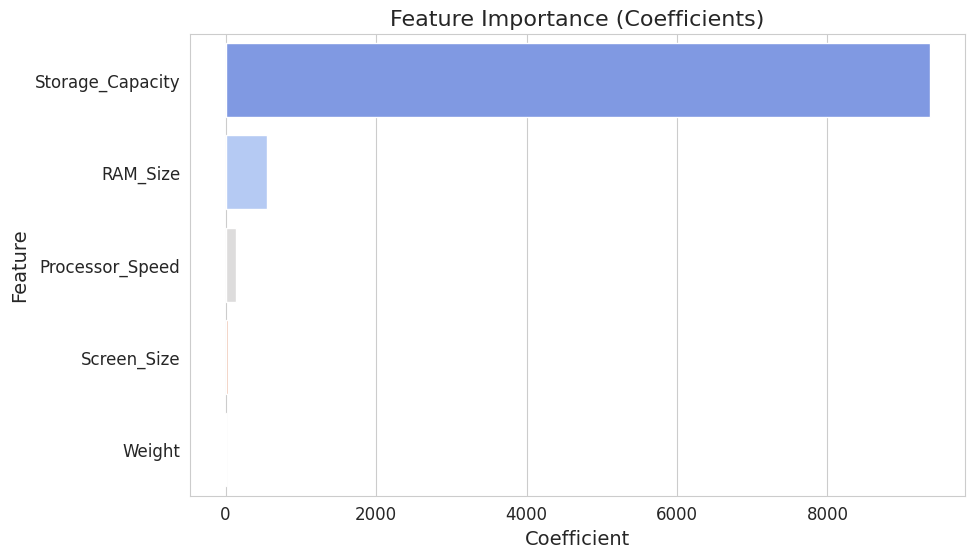

In [21]:
# Sort coefficients DataFrame by coefficient value
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

# Filter out specific features and only include single "brand" feature
coef_df_filtered = coef_df_sorted[~coef_df_sorted['Feature'].isin(['Brand_Asus', 'Brand_Acer', 'Brand_Dell', 'Brand_Lenovo', 'Brand_HP', 'Intercept'])]

# Feature Importance (Coefficients) Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_filtered, palette='coolwarm')
plt.title('Feature Importance (Coefficients)', fontsize=16)
plt.xlabel('Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Conclusion

## Summary of Model Performance

### Training R-squared:
The R-squared value measures the proportion of the variance in the target variable (laptop prices) that is predictable from the independent variables (features) in the model. A value of 1 indicates a perfect fit, while a value of 0 indicates no linear relationship. In this model, the training R-squared of 0.9995 suggests that 99.95% of the variance in laptop prices is explained by the features included in the model.

### Test R-squared:
Similar to training R-squared, test R-squared measures the goodness of fit of the model on unseen data (test set). A high test R-squared (0.9996 in this case) indicates that the model performs well on new data and can generalize effectively from the training set to unseen instances.

### Cross-validation R-squared scores:
Cross-validation is a technique used to assess the generalization performance of a model. This metric provides the R-squared scores obtained from cross-validating the model on different subsets of the data. The mean cross-validation R-squared score (0.9995) indicates the average performance of the model across multiple validation folds.

### Mean Squared Error (MSE):
The MSE measures the average squared difference between the predicted values and the actual values. Lower MSE values indicate better fit and prediction accuracy. The MSE of 32304.74 suggests that, on average, the squared difference between predicted and actual laptop prices is relatively small.

### Root Mean Squared Error (RMSE):
RMSE is the square root of the MSE and is interpreted in the same units as the target variable (laptop prices). It provides a measure of the average deviation of the predicted values from the actual values. The RMSE of 179.74 indicates that, on average, the model's predictions are approximately $179.74 away from the true laptop prices.

### Mean Absolute Error (MAE):
MAE measures the average absolute difference between the predicted values and the actual values. Like RMSE, it is interpreted in the same units as the target variable. The MAE of 146.22 suggests that, on average, the model's predictions are approximately $146.22 away from the true laptop prices.

### Number of outliers:
Outliers are data points that significantly deviate from the rest of the dataset. In this case, the absence of outliers (number = 0) indicates that the model does not encounter extreme values that could skew its predictions.

### Best Hyperparameters:
Hyperparameters are parameters set before the learning process begins. The best hyperparameters are those that optimize the model's performance. In this model, the best hyperparameter configuration includes setting 'fit_intercept' to True, indicating that the model includes an intercept term.

### Final Test R-squared:
This metric provides the R-squared value obtained when evaluating the model on the test dataset. It serves as a final assessment of the model's performance on unseen data, confirming its ability to generalize effectively.

## Conclusion

The linear regression model built for predicting laptop prices demonstrates exceptional performance across various evaluation metrics. With high R-squared values, low error metrics, and absence of outliers, the model exhibits a strong ability to capture the relationship between the input features and the target variable.

The consistency of performance across cross-validation folds further confirms the model's robustness. Overall, the model is deemed reliable for predicting laptop prices based on the provided features.